In [1]:
import numpy as np
from pathlib import Path
import Visualisation_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from active_learning import get_high_variance_cells

LOG_DIR = Path("log/active_learning/AL: testing")


In [2]:
with np.load(LOG_DIR / '0' / 'train' / 'val_predictions.npz') as npz_file:
    predict_points = npz_file['points']
    predict_preds = npz_file['preds']
    predict_target = npz_file['target']
    predict_variance = npz_file['variance']  # Variances are normalised to [-1,1]
    predict_point_variance = npz_file['point_variance']
    predict_grid_mask = npz_file['grid_mask']
    predict_features = npz_file['features']
    predict_samples_per_cell = npz_file['samples_per_cell']

In [3]:
with np.load('/home/luc/PycharmProjects/Pointnet_Pointnet2_pytorch/log/active_learning/AL: 50%start_20epoch_5%increase/0/train/val_predictions_special.npz') as npz_file:
    feat = npz_file['features']
    l0_points = npz_file['l0s']
    predict_points = npz_file['points']
    predict_preds = npz_file['preds']
    predict_target = npz_file['target']
    predict_variance = npz_file['variance']  # Variances are normalised to [-1,1]
    predict_point_variance = npz_file['point_variance']
    predict_grid_mask = npz_file['grid_mask']

## Checking normalize kmeans

100%|██████████| 199/199 [02:11<00:00,  1.52it/s]


Best num_clusters based on Silhouette:
sqeuclidean: [ 2 37 48 51 34 59 53 45 60 54 65 50 57 56]
cosine: [28  2 25 46 59 48 49 60 52 38 19 36 47 54]
canberra: [37  2 48 36 28 34 51 53 33 59 42 60 52 47]
braycurtis: [37  2 48 36 34 33 51 28 32 59 45 29 27 53]
correlation: [28 60 59 25 46 48 49 54 19 53 47 52 63 38]


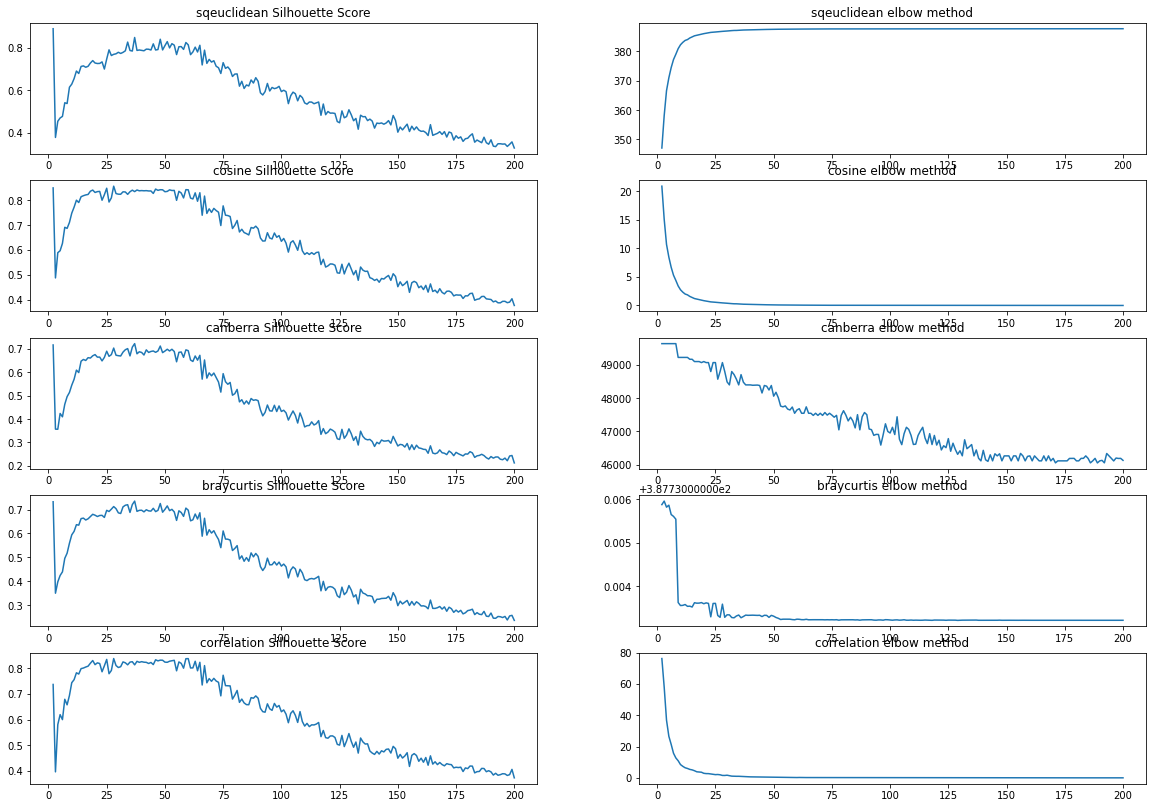

In [5]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import normalize

predict_features = feat

kmax = 200
distances_metrics = ['sqeuclidean', 'cosine', 'canberra','braycurtis', 'correlation']
l0sil = [[] for _ in range(len(distances_metrics))]
l0elbow = [[] for _ in range(len(distances_metrics))]

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax + 1)):
    kmeans = KMeans(n_clusters=k).fit(normalize(predict_features))
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(normalize(predict_features))

    for idx, dist_metric in enumerate(distances_metrics):
        l0sil[idx].append(silhouette_score(predict_features, labels, metric=dist_metric))

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        curr_sse = 0
        for i in range(len(predict_features)):
            curr_center = kmeans.cluster_centers_[pred_clusters[i]]
            if dist_metric == 'sqeuclidean':
                curr_sse += distance.sqeuclidean(predict_features[i], curr_center)
            elif dist_metric == 'cosine':
                curr_sse += distance.cosine(predict_features[i], curr_center)
            elif dist_metric == 'canberra':
                curr_sse += distance.canberra(predict_features[i], curr_center)
            elif dist_metric == 'braycurtis':
                curr_sse += distance.braycurtis(predict_features[i], curr_center)
            elif dist_metric == 'correlation':
                curr_sse += distance.correlation(predict_features[i], curr_center)

        l0elbow[idx].append(curr_sse)


fig, ax = plt.subplots(len(distances_metrics), 2, figsize=(20, 14))
print("Best num_clusters based on Silhouette:")
for i in range(len(distances_metrics)):
    ax[i][0].plot([None,None]+l0sil[i])
    ax[i][0].set_title(distances_metrics[i] + " Silhouette Score")
    print(f"{distances_metrics[i]}: {np.argsort(l0sil[i])[:-15:-1]+2}")
    ax[i][1].plot([None,None]+l0elbow[i])
    ax[i][1].set_title(distances_metrics[i] + " elbow method")

# Comparing features vs l0_points

100%|██████████| 199/199 [01:42<00:00,  1.95it/s]


Best num_clusters based on Silhouette:
sqeuclidean: [ 5  4  6  3  2 54 40 55 49 42 43 46 47 37]
cosine: [54 80 77 63 82 64 85 67 71 83 84 60 87 81]
canberra: [42 43 54 40 46 45 47 52 51 39 50 53 57 38]
braycurtis: [52 45 49 54 55 47 42 38 43 51 60 50 40 57]
correlation: [54 80 77 63 85 83 84 82 64 71 67 60 81 87]


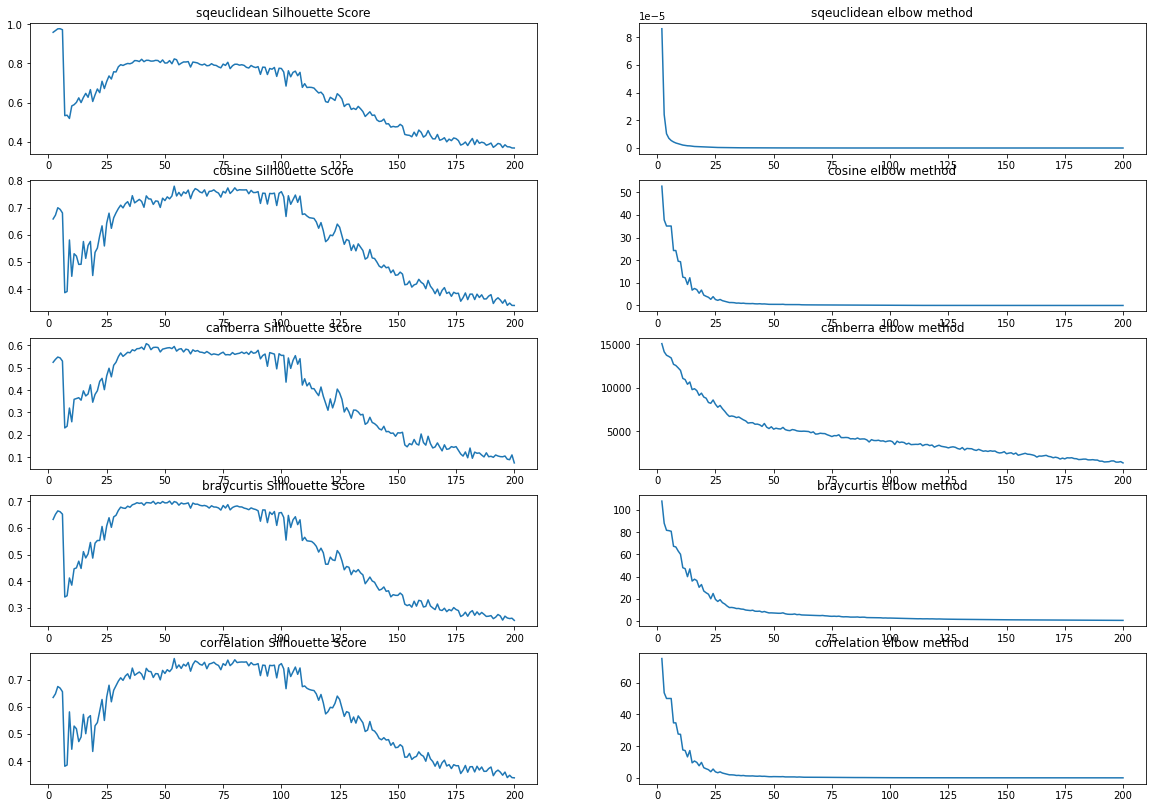

In [6]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial import distance

predict_features = l0_points

kmax = 200
distances_metrics = ['sqeuclidean', 'cosine', 'canberra','braycurtis', 'correlation']
l0sil = [[] for _ in range(len(distances_metrics))]
l0elbow = [[] for _ in range(len(distances_metrics))]

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax + 1)):
    kmeans = KMeans(n_clusters=k).fit(predict_features)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(predict_features)

    for idx, dist_metric in enumerate(distances_metrics):
        l0sil[idx].append(silhouette_score(predict_features, labels, metric=dist_metric))

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        curr_sse = 0
        for i in range(len(predict_features)):
            curr_center = kmeans.cluster_centers_[pred_clusters[i]]
            if dist_metric == 'sqeuclidean':
                curr_sse += distance.sqeuclidean(predict_features[i], curr_center)
            elif dist_metric == 'cosine':
                curr_sse += distance.cosine(predict_features[i], curr_center)
            elif dist_metric == 'canberra':
                curr_sse += distance.canberra(predict_features[i], curr_center)
            elif dist_metric == 'braycurtis':
                curr_sse += distance.braycurtis(predict_features[i], curr_center)
            elif dist_metric == 'correlation':
                curr_sse += distance.correlation(predict_features[i], curr_center)

        l0elbow[idx].append(curr_sse)


fig, ax = plt.subplots(len(distances_metrics), 2, figsize=(20, 14))
print("Best num_clusters based on Silhouette:")
for i in range(len(distances_metrics)):
    ax[i][0].plot([None,None]+l0sil[i])
    ax[i][0].set_title(distances_metrics[i] + " Silhouette Score")
    print(f"{distances_metrics[i]}: {np.argsort(l0sil[i])[:-15:-1]+2}")
    ax[i][1].plot([None,None]+l0elbow[i])
    ax[i][1].set_title(distances_metrics[i] + " elbow method")

100%|██████████| 199/199 [01:54<00:00,  1.73it/s]


Best num_clusters based on Silhouette:
sqeuclidean: [ 5  4  6  3  2 51 47 44 48 49 43 57 52 30]
cosine: [71 47  4 78 79 81 77 89 83 44 80 84  5 76]
canberra: [71 73 63 47 44 78 65 43  4 79 72 74  5 57]
braycurtis: [ 4  5  6  3 44 47 51 43 57 48 54 61 52 36]
correlation: [71 78 79 77 81 89 47 84 85 87 83 80 86 95]


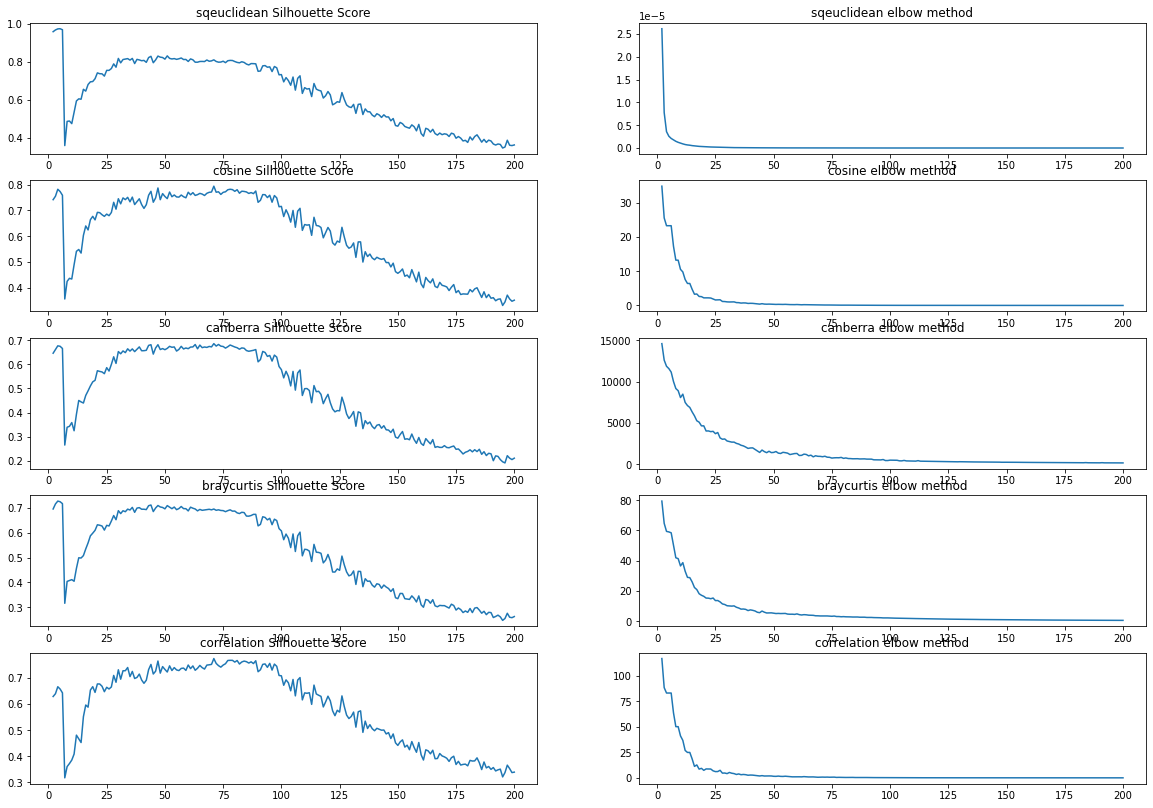

In [6]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial import distance

predict_features = feat

kmax = 200
distances_metrics = ['sqeuclidean', 'cosine', 'canberra','braycurtis', 'correlation']
sil = [[] for _ in range(len(distances_metrics))]
elbow = [[] for _ in range(len(distances_metrics))]

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax + 1)):
    kmeans = KMeans(n_clusters=k).fit(predict_features)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(predict_features)

    for idx, dist_metric in enumerate(distances_metrics):
        sil[idx].append(silhouette_score(predict_features, labels, metric=dist_metric))

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        curr_sse = 0
        for i in range(len(predict_features)):
            curr_center = kmeans.cluster_centers_[pred_clusters[i]]
            if dist_metric == 'sqeuclidean':
                curr_sse += distance.sqeuclidean(predict_features[i], curr_center)
            elif dist_metric == 'cosine':
                curr_sse += distance.cosine(predict_features[i], curr_center)
            elif dist_metric == 'canberra':
                curr_sse += distance.canberra(predict_features[i], curr_center)
            elif dist_metric == 'braycurtis':
                curr_sse += distance.braycurtis(predict_features[i], curr_center)
            elif dist_metric == 'correlation':
                curr_sse += distance.correlation(predict_features[i], curr_center)

        elbow[idx].append(curr_sse)


fig, ax = plt.subplots(len(distances_metrics), 2, figsize=(20, 14))
print("Best num_clusters based on Silhouette:")
for i in range(len(distances_metrics)):
    ax[i][0].plot([None,None]+sil[i])
    ax[i][0].set_title(distances_metrics[i] + " Silhouette Score")
    print(f"{distances_metrics[i]}: {np.argsort(sil[i])[:-15:-1]+2}")
    ax[i][1].plot([None,None]+elbow[i])
    ax[i][1].set_title(distances_metrics[i] + " elbow method")


Best num_clusters based on Silhouette:
sqeuclidean: [ 5  4  6  3  2 50 59 46 45 61 53 57 76 32]
cosine: [76  4 89 73 75 86 70 61 79 72 71 65 83 78]
canberra: [76 61 71 70 73  4 49 48 65 75  5 47 69 67]
braycurtis: [ 4  5  6  3 48 59 47 46 61 50 45 36 57 49]
correlation: [89 76 86 83 75 79 91 61 73 72 92 87 70 78]


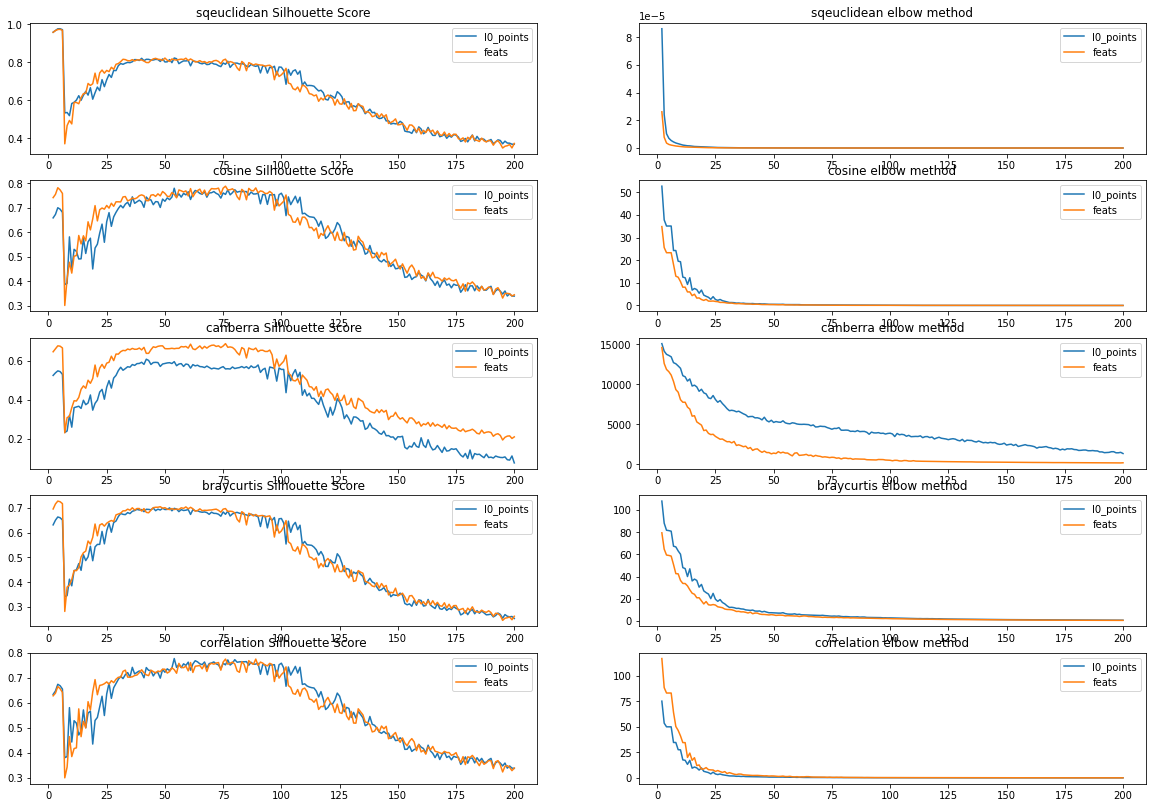

In [8]:
fig, ax = plt.subplots(len(distances_metrics), 2, figsize=(20, 14))
print("Best num_clusters based on Silhouette:")
for i in range(len(distances_metrics)):
    ax[i][0].plot([None,None]+l0sil[i], label='l0_points')
    ax[i][0].plot([None,None]+sil[i], label='feats')
    ax[i][0].set_title(distances_metrics[i] + " Silhouette Score")
    ax[i][0].legend()
    print(f"{distances_metrics[i]}: {np.argsort(sil[i])[:-15:-1]+2}")
    ax[i][1].plot([None,None]+l0elbow[i], label='l0_points')
    ax[i][1].plot([None,None]+elbow[i], label='feats')
    ax[i][1].set_title(distances_metrics[i] + " elbow method")
    ax[i][1].legend()

Seems to be that the features are better than the l0_points embeddings.

# Finding the optimal K

In [11]:
cell_centers = np.array(
    [np.mean(predict_points[np.where(predict_grid_mask == i)[0], :3], axis=0) for i in range(len(feat))])

(-50.0, 50.0)

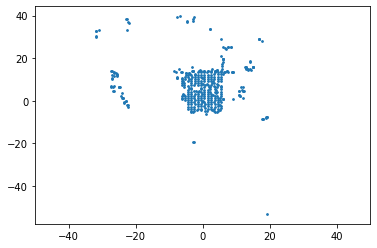

In [18]:
plt.scatter(cell_centers[:, 0], cell_centers[:, 1], s=3)
plt.xlim(-50, 50)
# plt.ylim(-10, 20)


In [54]:
variance_ordering_idxs = predict_variance.argsort()[::-1]
num_cells = 30

In [46]:
import matplotlib.pyplot as plt
from sklearn import cluster

In [55]:
kmeans = cluster.KMeans(n_clusters=num_cells, random_state=0).fit(predict_features)

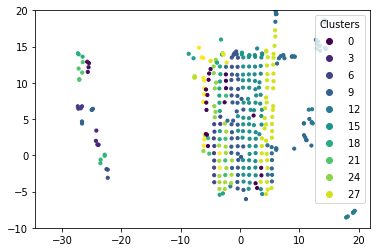

In [56]:
fig, ax = plt.subplots()
scatter = ax.scatter(cell_centers[:, 0], cell_centers[:, 1], c=kmeans.labels_, s=10)
# plt.xlim(-40, 60)
plt.ylim(-10, 20)

# add legend to plt
ax.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
plt.show()

Text(0.5, 0, 'Cluster')

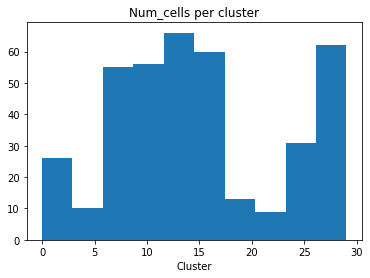

In [57]:
plt.hist(kmeans.labels_)
plt.title("Num_cells per cluster")
plt.xlabel("Cluster")

## Elbow and Silhouette Method

100%|██████████| 124/124 [00:52<00:00,  2.35it/s]


Best num_clusters based on Silhouette:
sqeuclidean: [ 4  5  3  6  2  7  9  8 10 12 11 46 49 78]
cosine: [ 71  73  78  95  93  92  91  89  97 100 102  85  90  68]
canberra: [73 78 74 95 77 75 76 71 81 72 67 84 68 69]
braycurtis: [73 78 74 71 46 75 67 77 76 69 70 72 68 49]
correlation: [ 71  73  78  95  93  91  92  89  97 100  85  90 102  68]


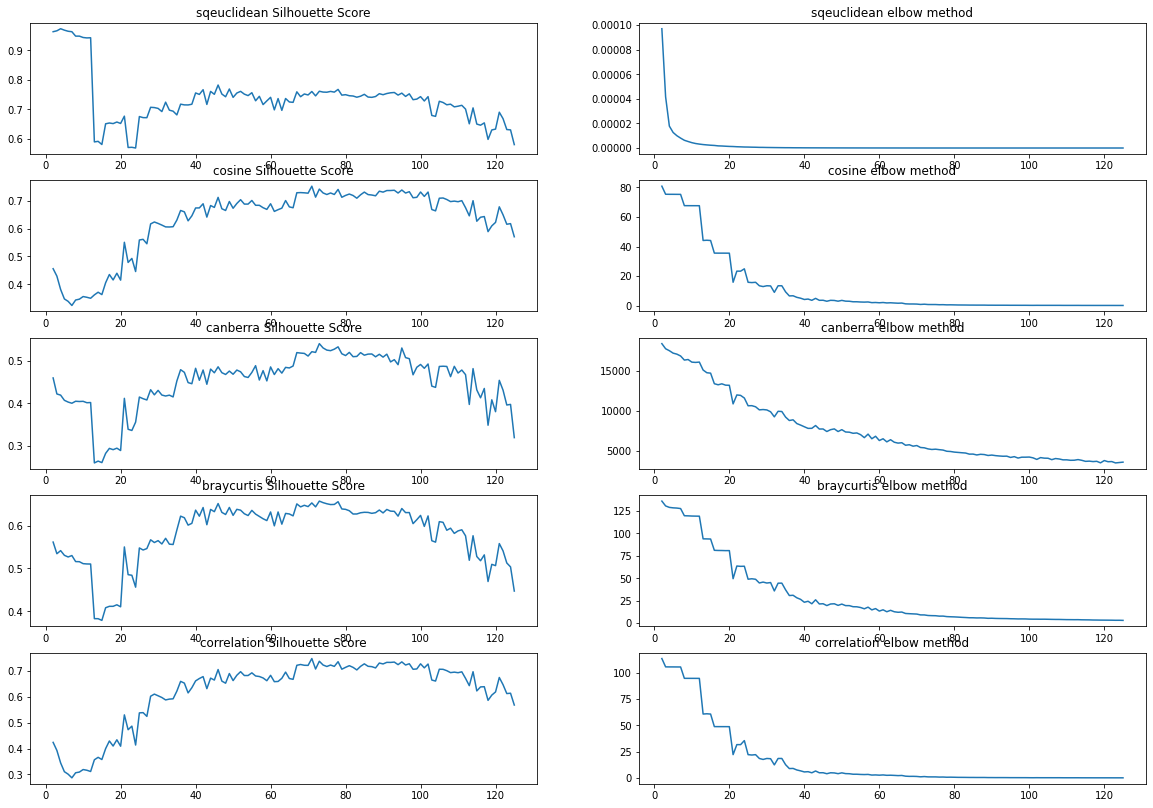

In [31]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial import distance


kmax = 125
distances_metrics = ['sqeuclidean', 'cosine', 'canberra','braycurtis', 'correlation']
sil = [[] for _ in range(len(distances_metrics))]
elbow = [[] for _ in range(len(distances_metrics))]

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm(range(2, kmax + 1)):
    kmeans = KMeans(n_clusters=k).fit(predict_features)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(predict_features)

    for idx, dist_metric in enumerate(distances_metrics):
        sil[idx].append(silhouette_score(predict_features, labels, metric=dist_metric))

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        curr_sse = 0
        for i in range(len(predict_features)):
            curr_center = kmeans.cluster_centers_[pred_clusters[i]]
            if dist_metric == 'sqeuclidean':
                curr_sse += distance.sqeuclidean(predict_features[i], curr_center)
            elif dist_metric == 'cosine':
                curr_sse += distance.cosine(predict_features[i], curr_center)
            elif dist_metric == 'canberra':
                curr_sse += distance.canberra(predict_features[i], curr_center)
            elif dist_metric == 'braycurtis':
                curr_sse += distance.braycurtis(predict_features[i], curr_center)
            elif dist_metric == 'correlation':
                curr_sse += distance.correlation(predict_features[i], curr_center)

        elbow[idx].append(curr_sse)


fig, ax = plt.subplots(len(distances_metrics), 2, figsize=(20, 14))
print("Best num_clusters based on Silhouette:")
for i in range(len(distances_metrics)):
    ax[i][0].plot([None,None]+sil[i])
    ax[i][0].set_title(distances_metrics[i] + " Silhouette Score")
    print(f"{distances_metrics[i]}: {np.argsort(sil[i])[:-15:-1]+2}")
    ax[i][1].plot([None,None]+elbow[i])
    ax[i][1].set_title(distances_metrics[i] + " elbow method")


# ReDAL
Score each sample with its uncertainty U

Clusters the samples into K clusters based on their feature embeddings

Sort the regions based on the uncertainty U

For each region, penalise the scores of the remaining regions in that cluster by some factor P

The result is a ranking of regions based on uncertainty and diversity (such that the most uncertain regions are ranked first, but repeat regions from the same cluster are unlikely).

In [ ]:
for idx in variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {predict_variance[idx]:.4f} ")

In [ ]:
penalty_factor = 0.9
adjusted_variance = np.copy(predict_variance)
for i, idx in enumerate(variance_ordering_idxs):
    current_cluster = kmeans.labels_[idx]
    for x in range(i + 1, len(variance_ordering_idxs)):
        x = variance_ordering_idxs[x]
        if kmeans.labels_[x] == current_cluster:
            adjusted_variance[x] *= penalty_factor

print(f"Old variance_ordering_idxs:\n{variance_ordering_idxs[:10]}")
adjusted_variance_ordering_idxs = adjusted_variance.argsort()[::-1]
print(f"New variance_ordering_idxs:\n{adjusted_variance_ordering_idxs[:10]}")
for idx in adjusted_variance_ordering_idxs:
    print(f"Idx {idx}, Cluster {kmeans.labels_[idx]},  variance {adjusted_variance[idx]:.4f}")